In [1]:
%pylab inline
import tensorflow as tf
import seaborn as sns
sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


The goal of this notebook is to implement a neural network in tensorflow that can classify a highly non-linearly separable dataset.

It will follow from: http://cs231n.github.io/neural-networks-case-study/

In [2]:
# Creating the dataset

N = 100 # number of points per class
D = 2 # dimensions of each point
K = 3 # number of classes

# note that we will have a total of N*K points
X = np.zeros((N*K, D)) #
Y_plot = np.zeros(N*K, dtype='int') # will hold just the class
Y = np.zeros((N*K,K), dtype='float') # will hold the one hot encoding for the class

for k in xrange(K):
    # k is the current class 
    ix = range(N*k, N*(k+1)) # the indexes that will be used.
    
    # game plan:
    # (1) calculate spherical coordinates
    # (2) change basis to x and y
    r = np.linspace(0, 1, N) # radii are distributed from 0 to N
    t = np.linspace( k*4, (k+1)*4, N ) + np.random.randn(N)*0.2 # theta values
    
    # concatenate x and y to each observation.
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y_plot[ix] = k # set the class.
    Y[ix,k] = 1

/Users/zaf/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


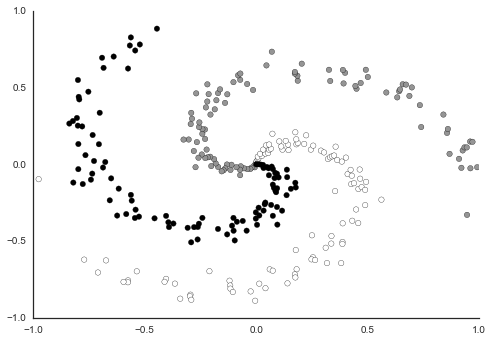

In [3]:
plt.scatter(X[:,0], X[:, 1], c=Y_plot, s=30)
plt.xlim([-1,1])
plt.ylim([-1,1])
sns.despine()

Now that we have some challenging data, let us first define a linear model that will try to classify this data.

# Multiple Logistic Regression

The logistic regression model tries to determine the probability of finding a binary $k$ given some data x. 

$$P(Y=1~|~X) = \frac{1}{1+\exp(-(W\cdot x + b))}$$

Where W and b is a matrix and vector to be learned from a training procedure. 

Here since we have $K$ classes, we cannot simply use linear regression. We instead resort to multiple logistic regression or "softmax" regression. Where

$$y = \text{softmax}(W\cdot x+b)$$

where $\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$

In [4]:
# x is a placeholder for the data. We define it such that 
# a D dimensional dataset will be provided to the algorithm
x = tf.placeholder(tf.float32, [None, D]) 


# W*x + b should be of dimension k
# since X is of dimension D
# we need W to be of dimension K x D
# recall matrix multiplication: (K x D) x (D, ) = (K, )
W = tf.Variable(tf.zeros([D, K]))
b = tf.Variable(tf.zeros([K]))


# turns out it's super simple to define softmax regression in 
# tensorflow:

y_pred = tf.nn.softmax(tf.matmul(x,W) + b)

To do any kind of machine learning we need to define a loss function that we will optimize (minimize):

$$H_{y'}(y) = -\sum_i y_i \log(y_i')$$

where y' is the predicted class and y is the true class.

In [5]:
y = tf.placeholder(tf.float32, [None, K]) # place holder for true classes.

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))

Tensorflow does automatic backprogation to calculate the rate of change of the error with respect to each of the parameters in the model. It will then update the parameters to reduce this error. A standard algorithm to do the update rules is Gradient descent which is conviniently implemented for us in tensorflow

In [6]:
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cross_entropy)

This little helper function will plot decision boundaries for us

In [7]:
def plot_decision_boundary(X,classifier_eqn, predictions, session,grid_size=0.02):
    
    # calculate the extent of the meshgrid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

    xx,yy = np.meshgrid(\
        np.arange(x_min, y_max, grid_size), \
                        np.arange(x_min, y_max, grid_size))

    # run the classifier on each point in the meshgrid
    decision_boundary_plots = np.argmax(session.run(classifier_eqn, feed_dict={x:np.c_[xx.ravel(), yy.ravel()]}),axis=1)

    decision_boundary_plots = decision_boundary_plots.reshape(xx.shape)
    
    # plot it 
    
    plt.contourf(xx,yy, decision_boundary_plots, cmap=plt.cm.Spectral)
    plt.scatter(X[:,0], X[:, 1], c=predictions, s=30, cmap=plt.cm.Spectral)
    

We now have all the elements of our model, tensorflow just handles the rest for us:

Turn 0 accuracy:0.52
Turn 100 accuracy:0.52
Turn 200 accuracy:0.516667
Turn 300 accuracy:0.52
Turn 400 accuracy:0.523333
Turn 500 accuracy:0.52
Turn 600 accuracy:0.52
Turn 700 accuracy:0.52
Turn 800 accuracy:0.52
Turn 900 accuracy:0.52


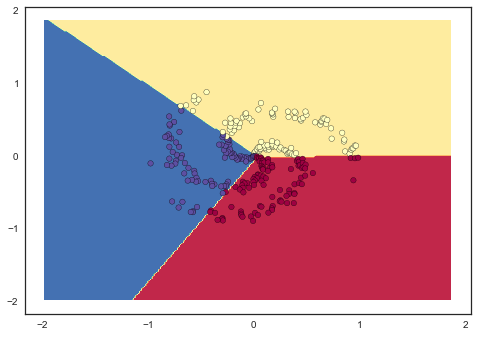

In [8]:
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    for i in range(1000): # run for 1000 steps
        
        # this does the training
        sess.run(train_step, feed_dict={x:X, y:Y})
        
        
        if i%100 == 0: # print every 100 steps only
            
            # calculate the accuracy of the mode:
            number_correct = tf.equal(tf.arg_max(y,1), tf.argmax(y_pred,1))
            accuracy = tf.reduce_mean(tf.cast(number_correct, tf.float32))
            print('Turn '+str(i)+' accuracy:'+str(sess.run(accuracy, feed_dict={x:X, y:Y})))
        
    Y_pred_classes = np.argmax(sess.run(y_pred, feed_dict={x:X}),1)
    plot_decision_boundary(X, y_pred, Y_pred_classes, sess)

Since this is a linear classifier, we see that the resulting decision boundaries are linear.

# Single Layer Neural Network

We now move to a non-linear model, since our main pain point previously was the linear decision boundaries, we now try to use a neural network that is known to be a "universal function approximator". We use a single layer network to demonstrate it's flexibility

In [14]:
x = tf.placeholder(tf.float32, (None, D))
y_true = tf.placeholder(tf.float32, (None, K))

H1 = 100 # size of hidden layer
WI1 = tf.Variable(initial_value=tf.random_normal((D,H1)))
W1O = tf.Variable(initial_value=tf.random_normal((H1,K)))

b1 = tf.Variable(initial_value=tf.random_normal((1,H1)))
b2 = tf.Variable(initial_value=tf.random_normal((1, K)))


hidden_layer = tf.nn.softmax(tf.matmul(x, WI1) + b1)
output = tf.matmul(hidden_layer, W1O) + b2

loss = tf.nn.softmax_cross_entropy_with_logits(output, y_true)


train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

First we train for 1000 steps to see how the decision boundary looks

Turn 0 accuracy:0.333333
Turn 100 accuracy:0.48
Turn 200 accuracy:0.493333
Turn 300 accuracy:0.503333
Turn 400 accuracy:0.526667
Turn 500 accuracy:0.536667
Turn 600 accuracy:0.546667
Turn 700 accuracy:0.553333
Turn 800 accuracy:0.56
Turn 900 accuracy:0.563333


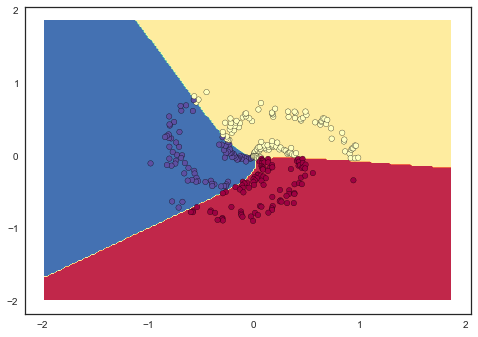

In [12]:
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    for i in range(1000):
        sess.run(train_step, feed_dict={x:X, y_true:Y})
        if i%100 == 0:
            number_correct = tf.equal(tf.arg_max(y_true,1), tf.argmax(output,1))
            accuracy = tf.reduce_mean(tf.cast(number_correct, tf.float32))
            print('Turn '+str(i)+' accuracy:'+str(sess.run(accuracy, feed_dict={x:X, y_true:Y})))
            
    y_preds = np.argmax(sess.run(output, feed_dict={x:X}),1)
    plot_decision_boundary(X, output, y_preds, sess)

That was pretty good, how about we make the training even longer?

Turn 0 accuracy:0.333333
Turn 1000 accuracy:0.61
Turn 2000 accuracy:0.646667
Turn 3000 accuracy:0.703333
Turn 4000 accuracy:0.74
Turn 5000 accuracy:0.763333
Turn 6000 accuracy:0.786667
Turn 7000 accuracy:0.796667
Turn 8000 accuracy:0.796667
Turn 9000 accuracy:0.8


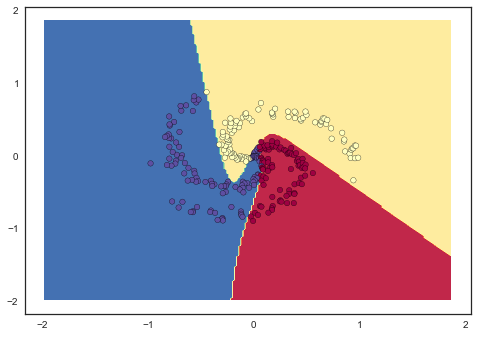

In [17]:
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10000):
        sess.run(train_step, feed_dict={x:X, y_true:Y})
        if i%1000 == 0:
            number_correct = tf.equal(tf.arg_max(y_true,1), tf.argmax(output,1))
            accuracy = tf.reduce_mean(tf.cast(number_correct, tf.float32))
            print('Turn '+str(i)+' accuracy:'+str(sess.run(accuracy, feed_dict={x:X, y_true:Y})))
            
    y_preds = np.argmax(sess.run(output, feed_dict={x:X}),1)
    plot_decision_boundary(X, output, y_preds, sess)